In [1]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind
from collections import Counter
from scipy.stats import shapiro
from scipy.stats import levene
import seaborn as sns
import matplotlib.pyplot as plt

# Set seed for reproducibility
np.random.seed(42)

In [2]:
def average_precision_at_k_subtype(row, k):
    relevant_count = 0
    precision_sum = 0
    for i in range(1, k+1):
        ret_site = row[f'ret_{i}_diagnosis']
        if ret_site is None:
            continue
        if ret_site == row['query_diagnosis']:
            relevant_count += 1
            precision_sum += relevant_count / i
    if relevant_count == 0:
        return 0
    return precision_sum / min(k, relevant_count)

def majority_voting_at_k_subtype(row, k):
    votes = []
    for i in range(1, k+1):
        ret_site = row[f'ret_{i}_diagnosis']
        if pd.isnull(ret_site):
            votes.append(-1)
        else:
            votes.append(ret_site)
    if not votes:
        return 0
    counter = Counter(votes)
    most_common = counter.most_common(1)
    if most_common[0][0] == row['query_diagnosis']:
        return 1
    elif most_common[0][0] == -1:
        return None
    else:
        return 0

def average_precision_at_k_site(row, k):
    relevant_count = 0
    precision_sum = 0
    for i in range(1, k+1):
        ret_site = row[f'ret_{i}_site']
        if ret_site is None:
            continue
        if ret_site == row['query_site']:
            relevant_count += 1
            precision_sum += relevant_count / i
    if relevant_count == 0:
        return 0
    return precision_sum / min(k, relevant_count)

def majority_voting_at_k_site(row, k):
    votes = []
    for i in range(1, k+1):
        ret_site = row[f'ret_{i}_site']
        if pd.isnull(ret_site):
            votes.append(-1)
        else:
            votes.append(ret_site)
    if not votes:
        return 0
    counter = Counter(votes)
    most_common = counter.most_common(1)
    if most_common[0][0] == row['query_site']:
        return 1
    elif most_common[0][0] == -1:
        return None
    else:
        return 0

## Independent T-test Explanation

The **independent T-test** is a statistical test that determines if there is a significant difference between the means of two independent groups. In this context, we are comparing the performance scores of images from two different Cohorts. By doing so, we aim to check if there's a statistically significant difference in the algorithm's performance based on the cohort used. If there's no significant difference, it might imply that the algorithm is robust against variations introduced by different scanning devices.

### Assumptions:
- **Independence of Groups**: The two cohort groups are independent of each other.
- **Normality**: The dependent variable (scores in this case) should be approximately normally distributed for each group. Before running the T-test, it's advisable to visually inspect the distribution of the data (e.g., using histograms or Q-Q plots) and, if necessary, test for normality (e.g., using the Shapiro-Wilk test).
- **Homogeneity of Variances**: The variances of the scores should be roughly equal in both groups. This can be tested with Levene's Test. If this assumption is violated, a variation of the T-test, like Welch's T-test, might be more appropriate.

**Note**: If the assumption of normality is seriously violated, consider a non-parametric alternative, like the Mann-Whitney U Test.


### Data Loading

In [3]:
model = "retccl"

df = pd.read_csv(f"../../data/{model}/BRCA_HER2/site.csv")
df_Her2Pos_site = df[df["query_name"].apply(lambda x: x.startswith("Her2Pos"))]
df_Her2Neg_site = df[df["query_name"].apply(lambda x: x.startswith("Her2Neg"))]

score_columns_site = []
for k in [10]:
    df_Her2Pos_site[f'MV_at_{k}_site'] = df_Her2Pos_site.apply(lambda row: majority_voting_at_k_site(row, k), axis=1)
    df_Her2Neg_site[f'MV_at_{k}_site'] = df_Her2Neg_site.apply(lambda row: majority_voting_at_k_site(row, k), axis=1)
    score_columns_site.append(f'MV_at_{k}_site')

for k in [5]:
    df_Her2Pos_site[f'AP_at_{k}_site'] = df_Her2Pos_site.apply(lambda row: average_precision_at_k_site(row, k), axis=1)
    df_Her2Neg_site[f'AP_at_{k}_site'] = df_Her2Neg_site.apply(lambda row: average_precision_at_k_site(row, k), axis=1)
    score_columns_site.append(f'AP_at_{k}_site')

/tmp/ipykernel_3898599/3849993769.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Her2Pos_site[f'MV_at_{k}_site'] = df_Her2Pos_site.apply(lambda row: majority_voting_at_k_site(row, k), axis=1)
/tmp/ipykernel_3898599/3849993769.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Her2Neg_site[f'MV_at_{k}_site'] = df_Her2Neg_site.apply(lambda row: majority_voting_at_k_site(row, k), axis=1)
/tmp/ipykernel_3898599/3849993769.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

### Normality Test using Shapiro-Wilk

In [4]:
# Testing for normality
for col in score_columns_site:
    stat_Her2Pos, p_Her2Pos = shapiro(df_Her2Pos_site[col])
    stat_Her2Neg, p_Her2Neg = shapiro(df_Her2Neg_site[col])
    
    print(f"Normality Test for {col} (cohort 1): Statistic = {stat_Her2Pos:.3f}, p-value = {p_Her2Pos:.16f}")
    print(f"Normality Test for {col} (cohort 2): Statistic = {stat_Her2Neg:.3f}, p-value = {p_Her2Neg:.16f}")
    
    # Decide whether to reject the null hypothesis
    alpha = 0.05
    if p_Her2Pos > alpha:
        print(f"{col} in cohort 1 looks Gaussian (fail to reject H0)")
    else:
        print(f"{col} in cohort 1 does not look Gaussian (reject H0)")
        
    if p_Her2Neg > alpha:
        print(f"{col} in cohort 2 looks Gaussian (fail to reject H0)\n")
    else:
        print(f"{col} in cohort 2 does not look Gaussian (reject H0)\n")

Normality Test for MV_at_10_site (cohort 1): Statistic = nan, p-value = 1.0000000000000000
Normality Test for MV_at_10_site (cohort 2): Statistic = nan, p-value = 1.0000000000000000
MV_at_10_site in cohort 1 looks Gaussian (fail to reject H0)
MV_at_10_site in cohort 2 looks Gaussian (fail to reject H0)

Normality Test for AP_at_5_site (cohort 1): Statistic = 0.913, p-value = 0.0000124392026919
Normality Test for AP_at_5_site (cohort 2): Statistic = 0.898, p-value = 0.0000014001487898
AP_at_5_site in cohort 1 does not look Gaussian (reject H0)
AP_at_5_site in cohort 2 does not look Gaussian (reject H0)



### Test for Homogeneity of Variances using Levene's Test

In [5]:
# Testing for homogeneity of variances
for col in score_columns_site:
    stat, p = levene(df_Her2Pos_site[col], df_Her2Neg_site[col])
    
    print(f"Levene's Test for {col}: Statistic = {stat:.3f}, p-value = {p:.16f}")
    
    # Decide whether to reject the null hypothesis
    if p > alpha:
        print(f"Variances for {col} seem equal across the two Cohorts (fail to reject H0)\n")
    else:
        print(f"Variances for {col} seem different across the two Cohorts (reject H0)\n")

Levene's Test for MV_at_10_site: Statistic = nan, p-value = nan
Variances for MV_at_10_site seem different across the two Cohorts (reject H0)

Levene's Test for AP_at_5_site: Statistic = 0.056, p-value = 0.8131243246669796
Variances for AP_at_5_site seem equal across the two Cohorts (fail to reject H0)



### Calculate the independent T-test for scores between the two Cohorts

In [6]:
for col in score_columns_site:
    t_stat, p_val = ttest_ind(df_Her2Pos_site[col], df_Her2Neg_site[col])
    print(f"For {col}: T-statistic = {t_stat:.3f}, p-value = {p_val:.16f}")

For MV_at_10_site: T-statistic = nan, p-value = nan
For AP_at_5_site: T-statistic = -5.983, p-value = 0.0000000107604654


## Interpretation of T-test Results

The results from the T-test provide insights about the difference in means between two groups for each metric. Here's a breakdown of the interpretation:

### Key Concepts:
- **T-statistic**: Reflects the difference in means relative to the variability within the groups. The sign of the T-statistic indicates which group has a larger mean. A positive T-statistic implies the first group (cohort 1) has a higher mean, while a negative T-statistic suggests the second group (cohort 2) has a higher mean.
  
- **p-value**: If the p-value is below a chosen threshold (commonly 0.05), the result is statistically significant, meaning there's sufficient evidence to reject the null hypothesis (i.e., the two groups have the same mean). A higher p-value suggests insufficient evidence to reject the null hypothesis.

### Results:

- **mv_1**: With a T-statistic of -2.828 and a p-value of 0.006, there's a statistically significant difference in the means. The negative T-statistic indicates the mean of `mv_1` for cohort 2 is higher than for cohort 1.

- **mv_3**: The T-statistic of 0.676 and a p-value of 0.501 suggest no statistically significant difference in means for this metric between the two Cohorts.

- **mv_5**: A T-statistic of 0.601 and p-value of 0.549 indicate no statistically significant difference in means.

- **mAP1**: The T-statistic is -0.789 with a p-value of 0.432, indicating no statistically significant difference.

- **mAP3**: With a T-statistic of 0.345 and a p-value of 0.731, there's no significant difference for this metric.

- **mAP5**: The T-statistic of -0.915 and a p-value of 0.363 suggest no significant difference.

In summary:
- Only the metric `mv_1` shows a statistically significant difference between the two Cohorts.
- The metrics `mv_3`, `mv_5`, `mAP1`, `mAP3`, and `mAP5` don't present any statistically significant difference when considering a significance level of 0.05.

**Note**: A statistically significant result doesn't necessarily indicate a practical significance. It's crucial to consider the context and magnitude of the differences when making conclusions.


/home/mxn2498/miniconda3/envs/search1/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mxn2498/miniconda3/envs/search1/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mxn2498/miniconda3/envs/search1/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


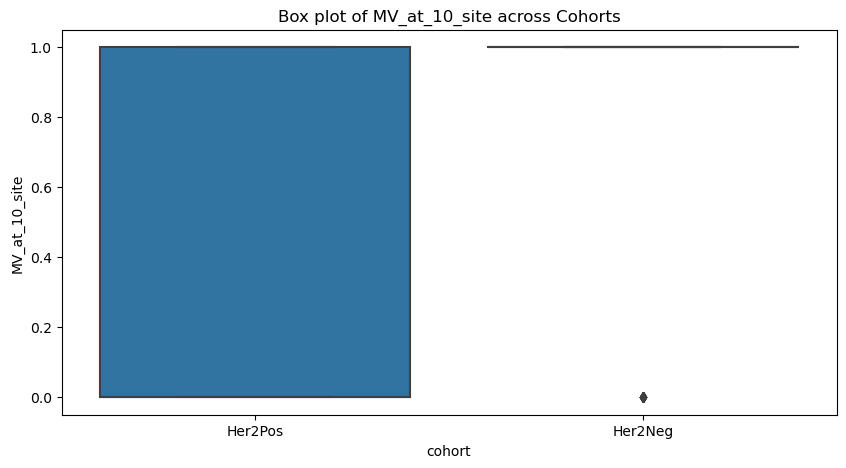

/home/mxn2498/miniconda3/envs/search1/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mxn2498/miniconda3/envs/search1/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/mxn2498/miniconda3/envs/search1/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mxn2498/miniconda3/envs/search1/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and wil

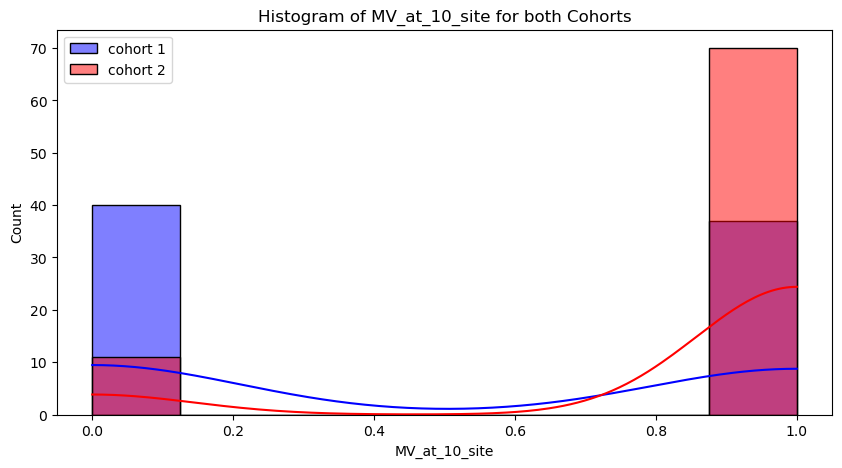

/home/mxn2498/miniconda3/envs/search1/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mxn2498/miniconda3/envs/search1/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mxn2498/miniconda3/envs/search1/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


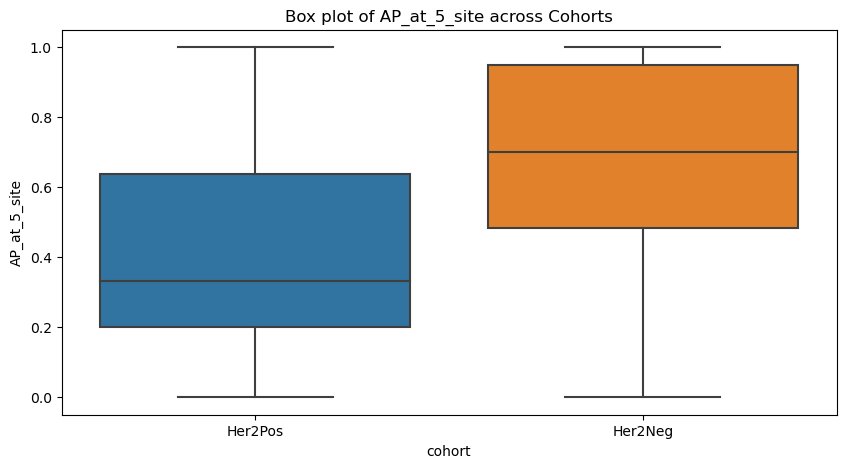

/home/mxn2498/miniconda3/envs/search1/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mxn2498/miniconda3/envs/search1/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/mxn2498/miniconda3/envs/search1/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mxn2498/miniconda3/envs/search1/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and wil

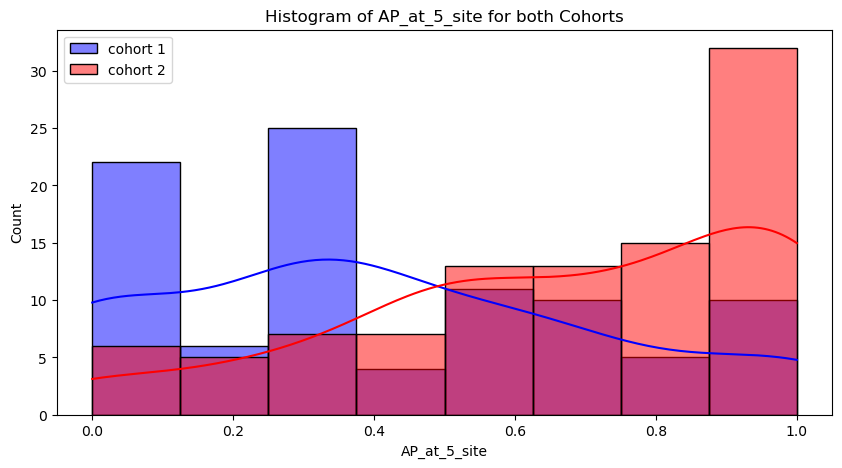

In [7]:
# Plotting for t-test and Mann-Whitney U Test
for metric in score_columns_site:
    plt.figure(figsize=(10, 5))
    
    # Boxplot
    data_to_plot = pd.concat([df_Her2Pos_site[[metric]].assign(cohort='Her2Pos'), df_Her2Neg_site[[metric]].assign(cohort='Her2Neg')])
    sns.boxplot(x='cohort', y=metric, data=data_to_plot)
    plt.title(f'Box plot of {metric} across Cohorts')
    plt.show()
    
    # Histogram
    plt.figure(figsize=(10, 5))
    sns.histplot(df_Her2Pos_site[metric], label='cohort 1', kde=True, color='blue', alpha=0.5)
    sns.histplot(df_Her2Neg_site[metric], label='cohort 2', kde=True, color='red', alpha=0.5)
    plt.legend()
    plt.title(f'Histogram of {metric} for both Cohorts')
    plt.show()

/tmp/ipykernel_3898599/1721502536.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Her2Pos_site['cohort'] = 'Her2Pos'
/tmp/ipykernel_3898599/1721502536.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Her2Neg_site['cohort'] = 'Her2Neg'
/home/mxn2498/miniconda3/envs/search1/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical

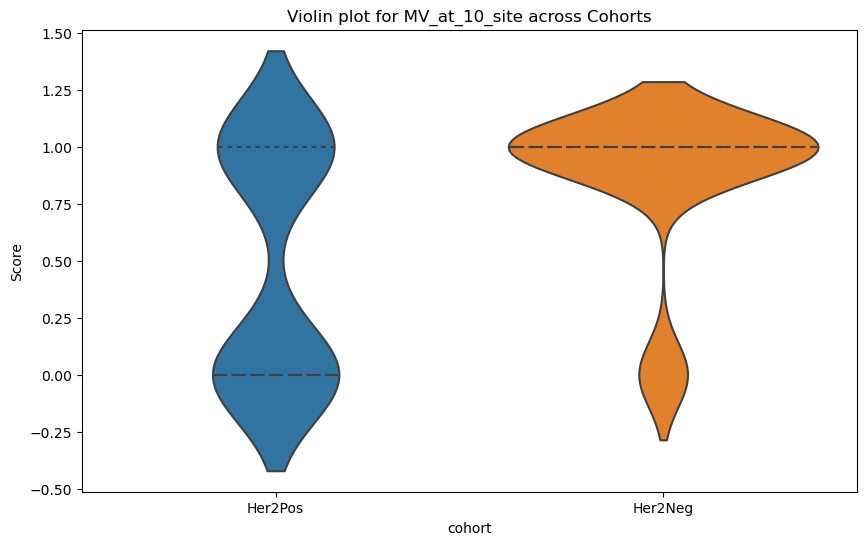

/home/mxn2498/miniconda3/envs/search1/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mxn2498/miniconda3/envs/search1/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mxn2498/miniconda3/envs/search1/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


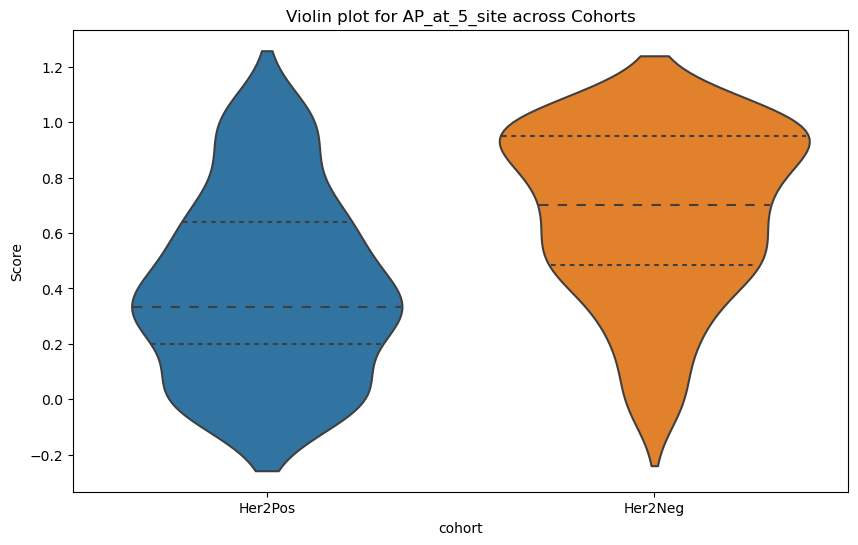

In [8]:
# Merging the two dataframes for plotting purposes
df_Her2Pos_site['cohort'] = 'Her2Pos'
df_Her2Neg_site['cohort'] = 'Her2Neg'
combined_df = pd.concat([df_Her2Pos_site, df_Her2Neg_site], ignore_index=True)

for metric in score_columns_site:
    plt.figure(figsize=(10, 6))
    sns.violinplot(x='cohort', y=metric, data=combined_df, inner="quartile")
    plt.title(f'Violin plot for {metric} across Cohorts')
    plt.ylabel('Score')
    plt.xlabel('cohort')
    plt.show()